In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Input
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv1D, Conv2D, Dense, BatchNormalization, Flatten, MaxPooling2D, Activation
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [6]:
#download the weather images and put them in a directory
path = r"C:\Users\user\OneDrive\Documents\Data Analysis Course\Machine Learning\Climate Wins\2. Data Sets\Multi-class Weather Dataset"
folders = os.listdir(path)
print(folders)

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [12]:
from tensorflow.keras import layers
#this will load in the pictures and rescale them to 250x250pixels

train_generator = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(250, 250),
    batch_size=32
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(250, 250),
    batch_size=32
)

# Normalize images
normalization_layer = layers.Rescaling(1./255)
train_generator = train_generator.map(lambda x, y: (normalization_layer(x), y))
test_generator = test_generator.map(lambda x, y: (normalization_layer(x), y))

Found 1125 files belonging to 4 classes.
Using 900 files for training.
Found 1125 files belonging to 4 classes.
Using 225 files for validation.


In [13]:
#this is a CNN to categorize the weather images

inputs = Input(shape=(250, 250, 3))

x = Conv2D(32, (5,5), activation = 'relu')(inputs)
x = MaxPooling2D(3,3)(x)
x = Conv2D(64, (5,5) , activation = 'relu')(x)
x = MaxPooling2D((3,3))(x)
x = Conv2D(128 , (5,5) , activation = 'relu')(x)
x = MaxPooling2D(3,3)(x)
x = Flatten()(x)
x = Dropout(0.5, seed = 5)(x)
x = Dense(128 , activation = 'relu')(x)

outputs = Dense(4, activation = 'softmax')(x)

model:Model = Model(inputs=inputs, outputs=outputs)

In [17]:
# Count the number of subfolders = number of classes
class_names = sorted(os.listdir(path))
print("Class names:", class_names)
num_classes = len(class_names)
print("Number of classes:", num_classes)

Class names: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Number of classes: 4


In [31]:
#compile and run the model
#how many epochs are required to generate an accurate model?

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.fit(
    train_generator, 
    epochs=20,  # You can change this to more for better accuracy
    validation_data=test_generator
)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 553ms/step - accuracy: 0.8540 - loss: 0.4026 - val_accuracy: 0.8267 - val_loss: 0.4806
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 550ms/step - accuracy: 0.9257 - loss: 0.2238 - val_accuracy: 0.8978 - val_loss: 0.2712
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 540ms/step - accuracy: 0.9245 - loss: 0.1987 - val_accuracy: 0.9022 - val_loss: 0.4240
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 545ms/step - accuracy: 0.9370 - loss: 0.2060 - val_accuracy: 0.8089 - val_loss: 0.4641
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 544ms/step - accuracy: 0.8870 - loss: 0.2785 - val_accuracy: 0.8711 - val_loss: 0.3794
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 545ms/step - accuracy: 0.9078 - loss: 0.2372 - val_accuracy: 0.8578 - val_loss: 0.4492
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.9102 - loss: 0.2340 - val_accuracy: 0.8400 - val_loss: 0.5648
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 551ms/step - accuracy: 0.9198 - loss: 0.2202 - val_accu

In [32]:
results = pd.DataFrame(model.history.history)

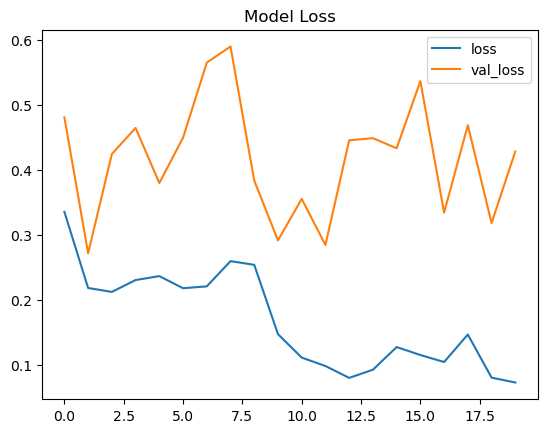

In [33]:
results[['loss','val_loss']].plot(title='Model Loss')
plt.savefig('./loss.png')

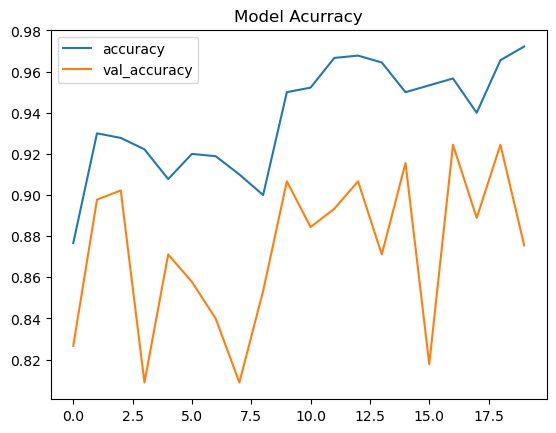

In [34]:
results[['accuracy','val_accuracy']].plot(title='Model Acurracy')
plt.savefig('./accuracy.png')

In [35]:
# Print the accuracy and loss
print("Accuracy: {}, Val_Accuracy: {}".format(results['accuracy'].iloc[-1], results['val_accuracy'].iloc[-1]))
print("Loss: {}, Val_Loss: {}".format(results['loss'].iloc[-1], results['val_loss'].iloc[-1]))

Accuracy: 0.9722222089767456, Val_Accuracy: 0.8755555748939514
Loss: 0.07232866436243057, Val_Loss: 0.42793968319892883


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


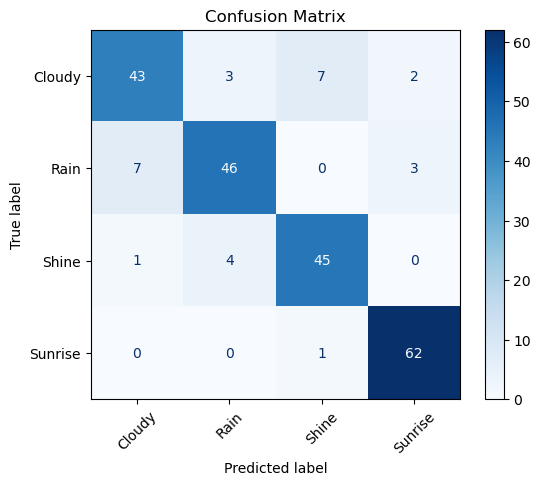

In [36]:
# collect n batches of images and display the confusion matrix for them.

class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
n = 7 #<--you can change the number of batches selected.

# iterator for the dataset
test_iter = iter(test_generator)

# first batch
image_batch, classes_batch = next(test_iter)

# Concatenate additional batches
for batch in range(n-1):
    temp_images, temp_labels = next(test_iter)
    image_batch = np.concatenate((image_batch, temp_images))
    classes_batch = np.concatenate((classes_batch, temp_labels))

# Predict on combined images
y_predict = model.predict(image_batch)

# Convert predictions and true labels to integer class indices
y_pred_int = np.argmax(y_predict, axis=1)         # predicted class indices
y_true_int = classes_batch.astype(int)            # true class indices (already integers)

# Confusion matrix
cm = confusion_matrix(y_true=y_true_int, y_pred=y_pred_int)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [37]:
#This function will display a number of random images as well as the predictions for the type of weather.

def predict_one(model, num_images=None):  
    # Convert tf.data.Dataset to an iterator
    test_iter = iter(test_generator)

    # Get one batch
    image_batch, classes_batch = next(test_iter)

    # Run predictions
    predicted_batch = model.predict(image_batch)

    # If num_images is None, show all images in batch
    n = image_batch.shape[0] if num_images is None else num_images  

    for k in range(n):
        image = image_batch[k].numpy()  # Convert to NumPy for matplotlib
        real_class = class_names[np.argmax(classes_batch[k])]
        predicted_class = class_names[np.argmax(predicted_batch[k])]
        value_predicted = predicted_batch[k]
        isTrue = (real_class == predicted_class)

        plt.figure(k)
        plt.title(
            ("Correct Prediction" if isTrue else "Incorrect Prediction") +
            f" - class: {real_class} - predicted: {predicted_class} - {value_predicted}"
        )
        plt.axis('off')
        plt.imshow(image)
        plt.savefig(f'./{real_class}_{predicted_class}_{np.max(value_predicted):.2f}.png')
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


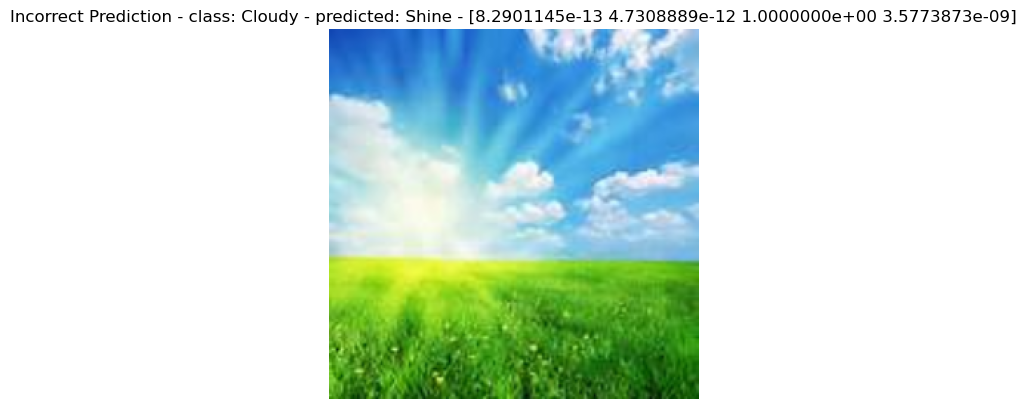

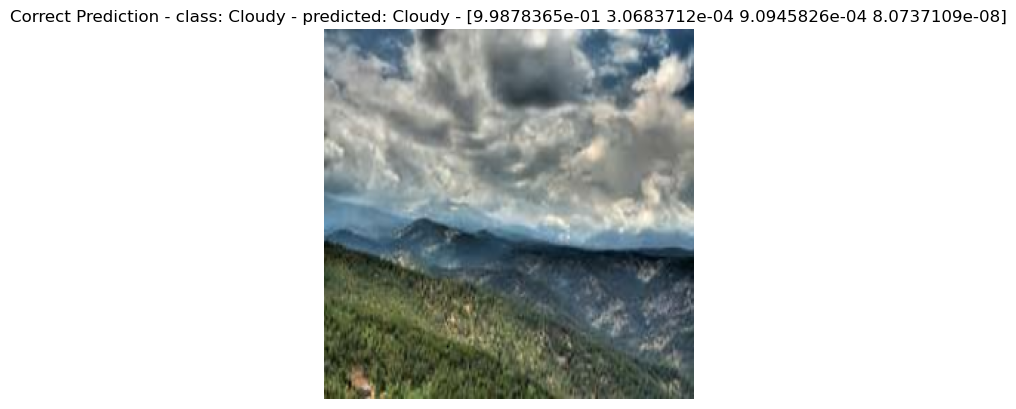

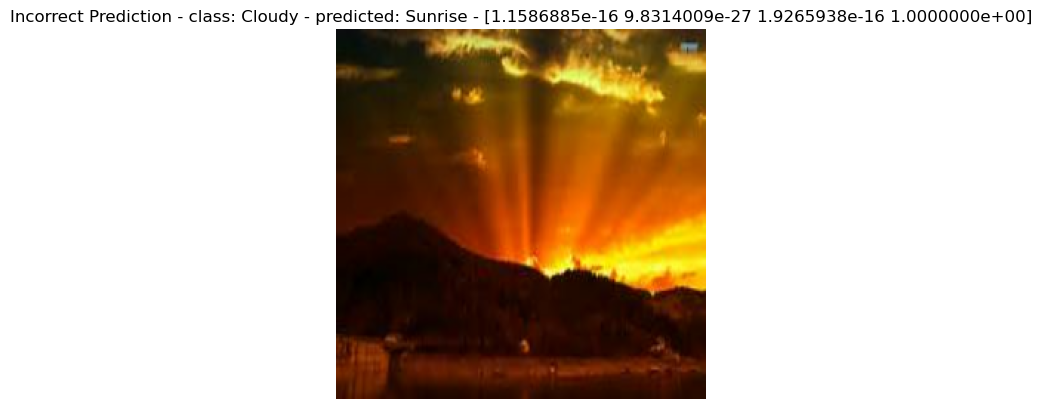

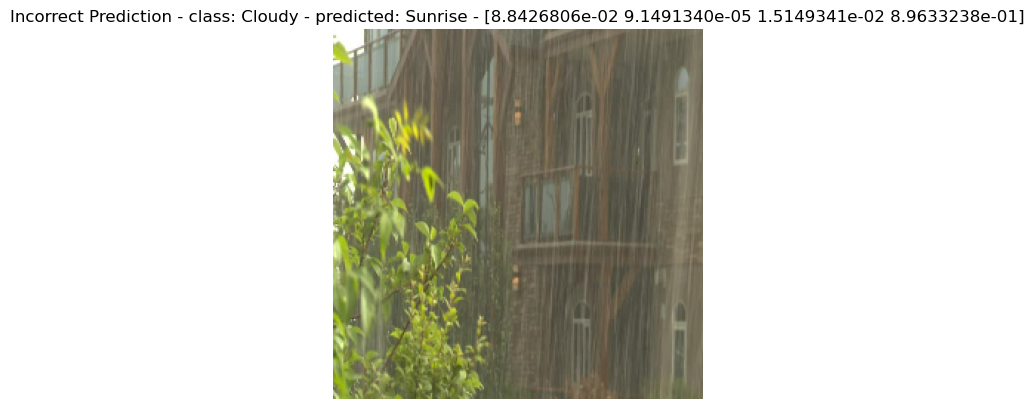

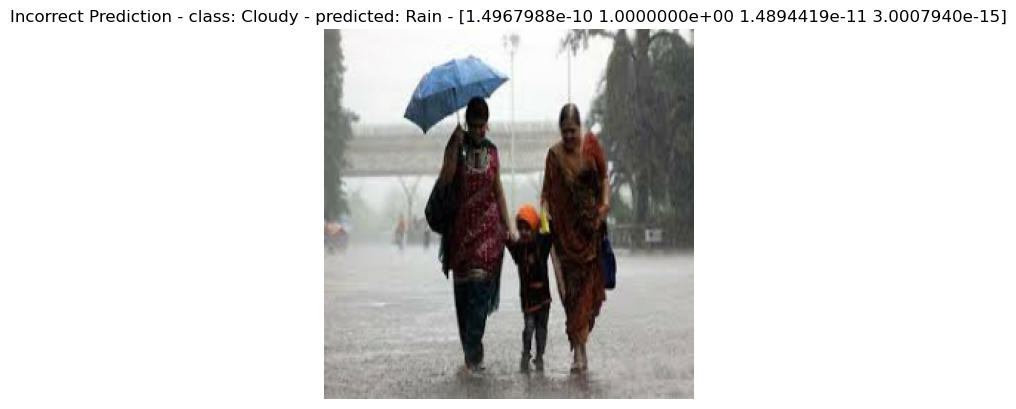

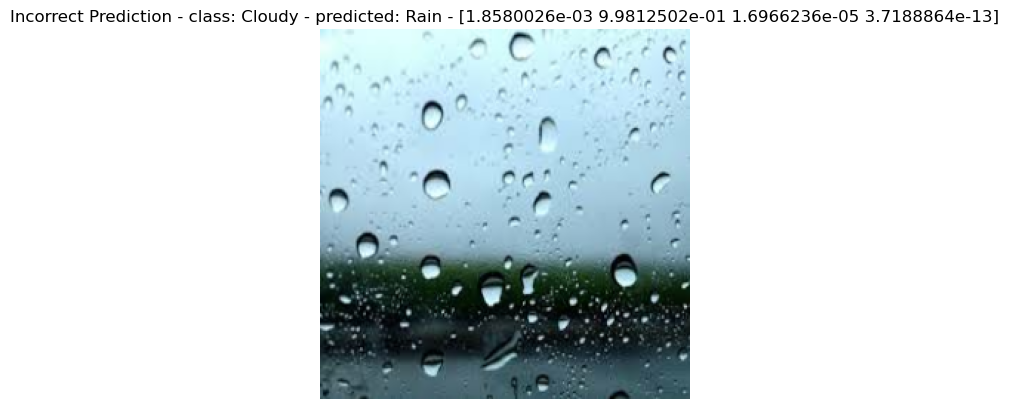

In [44]:
predict_one(model, 6) #<--you can show multiple pictures with this command. Just fill in the number you want to see.

I originally did 10 epochs with the strongest being epoch 10:

Accuracy: 0.903333306312561, Val_Accuracy: 0.8666666746139526
Loss: 0.26938918232917786, Val_Loss: 0.34854966402053833. 

I changed it to 20 to then end up with the current number 19 being the strongest. For maximum accuracy and low loss, i would assume that maybe about 40 epochs would reveal one of the strongest models.

Predictions seem to be off.